# Training and Validation

First lets take a look at some example images in the dataset. To understand what is being looked at by the machine. Then we will go onto augmenting them and training our classifier. Finally the accuracy of the model will be evaluated and along with using predictions we can assess the recaLL, precisiona and F1 score. Finally be benchmarked against a zero-rule algorithm and a random classifier. 

The dataset consists of 20 different Pokémon. The images will be trained on a convolutional neural network. The images have been previsouly normalised and labels encoded appropriately.



### Preparation

In [1]:
# import necessary modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.utils import np_utils
import warnings
import pickle

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Load data from pickle
# training images and labels
train_features, train_transformed_labels = pickle.load(open('training', mode='rb'))

# validation images and labels
validation_features, validation_transformed_labels = pickle.load(open('validation', mode='rb'))

# named labels ie. not encoded
train_named_labels, validation_named_labels = pickle.load(open('named_labels', mode='rb'))

### Augmented Images Using ImageDataGenerator

Due to the fact that there are not thousanads of images to train on it is probably a good idea to creat some synthetic images. This will be done using Keras' function `ImageDataGenerator`

In [3]:
# Generate batches of tensor image data with real-time data augmentation

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)


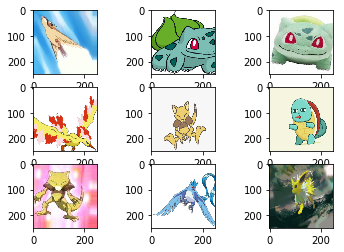

In [100]:
# examples of image augmentation
for X_batch, y_batch in datagen.flow(train_features, train_labels_le, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
        # show the plot
    plt.show()
    break


### Build model architecture

In [16]:
# construct model architecture
model = Sequential([
        
    Conv2D(32, (5, 5), input_shape=(250,250, 3)),
    Activation("relu"),
    MaxPooling2D((2,2)),
        
    Conv2D(64, (5, 5)),
    Activation("relu"),
    MaxPooling2D((2,2)),

    ])

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [6]:
# print summary of model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 246, 246, 32)      2432      
_________________________________________________________________
activation_1 (Activation)    (None, 246, 246, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 119, 119, 64)      51264     
_________________________________________________________________
activation_2 (Activation)    (None, 119, 119, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 222784)            0         
__________

In [17]:
# set up parameters for model
batch_size = 32
warnings.filterwarnings("ignore",category=UserWarning)
history = History()
epochs = 10

# fit model
history = model.fit_generator(datagen.flow(train_features, train_transformed_labels, batch_size=batch_size),
                    steps_per_epoch=features.shape[0],
                    epochs=epochs,
                    validation_data=(validation_features, validation_transform_labels),
                    callbacks=[history,
                               EarlyStopping(monitor='val_acc', patience=5, verbose=0),
                               ModelCheckpoint('models/model.h5', save_best_only=True,monitor='val_acc')
                              ]
                    )

Epoch 1/10
617/617 [==============================] - 208s - loss: 2.5333 - acc: 0.2124 - val_loss: 2.2827 - val_acc: 0.2650
Epoch 2/10
617/617 [==============================] - 204s - loss: 1.6923 - acc: 0.4560 - val_loss: 1.5711 - val_acc: 0.5200
Epoch 3/10
617/617 [==============================] - 234s - loss: 1.1938 - acc: 0.6170 - val_loss: 1.4491 - val_acc: 0.6150
Epoch 4/10
617/617 [==============================] - 237s - loss: 0.8730 - acc: 0.7232 - val_loss: 1.3126 - val_acc: 0.6450
Epoch 5/10
617/617 [==============================] - 210s - loss: 0.6756 - acc: 0.7824 - val_loss: 1.3059 - val_acc: 0.6900
Epoch 6/10
617/617 [==============================] - 210s - loss: 0.5666 - acc: 0.8173 - val_loss: 1.3476 - val_acc: 0.6850
Epoch 7/10
617/617 [==============================] - 211s - loss: 0.4812 - acc: 0.8458 - val_loss: 1.5634 - val_acc: 0.7150
Epoch 8/10
617/617 [==============================] - 211s - loss: 0.4197 - acc: 0.8640 - val_loss: 1.6051 - val_acc: 0.7250


In [91]:
# save hsitory information to file
with open('train_history_dict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# Accuracy by Epoch


In [4]:
from keras.models import load_model

# load model and history if necessary
model = load_model('models/model.h5')
history = pickle.load(open('train_history_dict', mode='rb'))

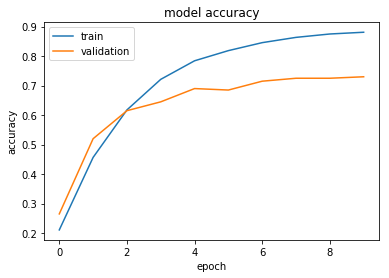

In [20]:
# plot accuracy on training and validation data
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [97]:
#Predicting values for test and train for model evaluation
predict_classes_train = model.predict_classes(train_features, batch_size=32)
predict_classes_validation  = model.predict_classes(validation_features, batch_size=32)

200/200 [==============================] - 0s     


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# encode names of Pokémon to compare against model class predictions for training images
le.fit(train_named_labels)
train_labels_le = le.transform(train_named_labels)

In [7]:
# same fopr validation images
le.fit(validation_named_labels)
validation_labels_le = le.transform(validation_named_labels)

# Metrics across all classes

In [101]:
print ('Accuracy for training:','{:.1%}'.format(accuracy_score(y_pred=predict_classes_train,y_true=train_labels_le)))
print ('\n')
print ('Accuracy for validation:','{:.1%}'.format(accuracy_score(y_pred=predict_classes_validation,y_true=validation_labels_le)))

Accuracy for training: 99.5%


Accuracy for validation: 73.0%


In [86]:
print ('Recall for training:','{:.1%}'.format(recall_score(y_pred=predict_classes_train,y_true=train_labels_le, average='macro')))
print ('\n')
print ('Recall for validation:','{:.1%}'.format(recall_score(y_pred=predict_classes_validation,y_true=validation_labels_le, average='macro')))

Recall for training: 99.5%


Recall for validation: 73.1%


In [89]:
print ('Precision for training:','{:.1%}'.format(precision_score(y_pred=predict_classes_train,y_true=train_labels_le, average='macro')))
print ('\n')
print ('Precision for validation:','{:.1%}'.format(precision_score(y_pred=predict_classes_validation,y_true=validation_labels_le, average='macro')))

Precision for training: 99.6%


Precision for validation: 77.0%


In [90]:
print ('f1 score for training:', '{:.1%}'.format(f1_score(y_pred=predict_classes_train,y_true=train_labels_le, average='macro')))
print ('\n')
print ('f1 score for validation:','{:.1%}'.format(f1_score(y_pred=predict_classes_validation,y_true=validation_labels_le, average='macro')))

f1 score for training: 99.5%


f1 score for validation: 72.5%


# Metrics for each class

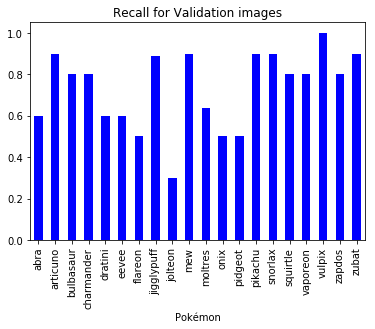

In [124]:
recall_all_train = recall_score(y_pred=predict_classes_train,y_true=train_labels_le,average=None)
recall_all_validation = recall_score(y_pred=predict_classes_validation,y_true=validation_labels_le, average=None)

recall_df = pd.DataFrame({'Pokémon': pokemon_names, 'Percentage':recall_all_validation})
recall_df.plot('Pokémon', 'Percentage', kind='bar', color='b', title='Recall for Validation images', legend=False)
plt.show()

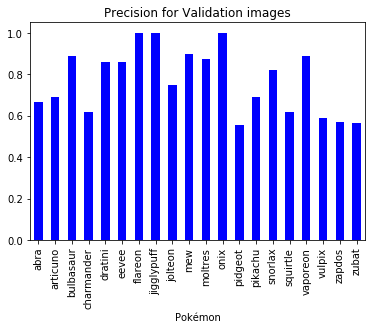

In [125]:
precision_all_train = precision_score(y_pred=predict_classes_train,y_true=train_labels_le, average=None)
precision_all_validation = precision_score(y_pred=predict_classes_validation,y_true=validation_labels_le, average=None)

precision_df = pd.DataFrame({'Pokémon': pokemon_names, 'Percentage':precision_all_validation})
precision_df.plot('Pokémon', 'Percentage', kind='bar', color='b',  title='Precision for Validation images', legend=False)
plt.show()

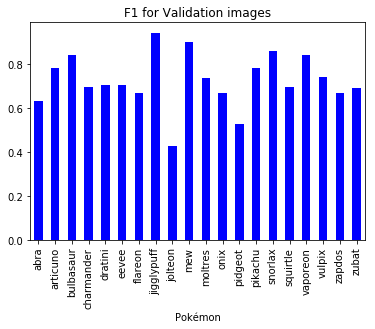

In [127]:
f1_all_train = f1_score(y_pred=predict_classes_train,y_true=train_labels_le, average=None)
f1_all_validation = f1_score(y_pred=predict_classes_validation,y_true=validation_labels_le, average=None)

f1_df = pd.DataFrame({'Pokémon': pokemon_names, 'Percentage':f1_all_validation})
f1_df.plot('Pokémon', 'Percentage', kind='bar', color='b',  title='F1 for Validation images', legend=False)
plt.show()

# Benchmark implementation

Dummy Classification Algorithm

In [5]:
from sklearn.dummy import DummyClassifier

# Construct dummy classifier

clf = DummyClassifier(strategy='stratified',random_state=0)
clf.fit(train_features, train_transformed_labels)

 # accuracy of dummy classifier


ValueError: Found array with dim 4. Estimator expected <= 2.

Comparing these benchmarks to the CNN model we can see that that the model at least out performs stratified dummy classification.

# Which Pokémon does the machine think it is? Class probability

In [72]:
# example images and their associated class prediction

predicted_image_proba = model.predict(train_features, batch_size=32, verbose=1)

617/617 [==============================] - 2s     


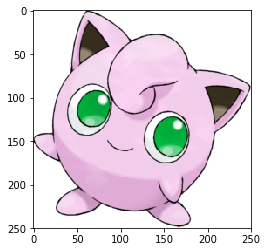

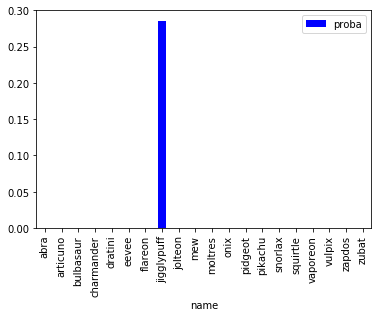

In [77]:
pokemon_names = np.unique(train_named_labels)
first_image_predictions = predicted_image_proba[200]
plt.imshow(train_features[200])

prediction_df = pd.DataFrame({'name': pokemon_names, 'proba':first_image_predictions})

prediction_df.plot('name', 'proba', kind='bar', color='b')

# Hyper Parameter Tuning and Optimisation


In [ ]:
#Parameter tuning, not sure how to do this with data generator
! --pip install hyperas
def build_classifier(optimizer, dropout1):
    model = Sequential([

    Conv2D(32, (5, 5), input_shape=(250,250, 3)),
    Activation("relu"),
    MaxPooling2D((2,2)),

    Conv2D(64, (5, 5)),
    Activation("relu"),
    MaxPooling2D((2,2)),

    ])

    model.add(Flatten())  
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20))
    model.add(Activation('sigmoid'))

    model.compile(loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=build_classifier)

parameters = {'batch_size': [32],
              'epochs': [10,15,20],
              'optimizer': ['adam', 'rmsprop'],
              'dropout1' : [0.25,0.5,0.75]
              }

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(train_features, train_labels_le)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))